In [79]:
# Import necessary packages

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import models,transforms
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
import csv
import collections
import PIL.Image
from aif360.algorithms.postprocessing import (CalibratedEqOddsPostprocessing, EqOddsPostprocessing,RejectOptionClassification)
from aif360.datasets import StandardDataset
import scipy.io




In [3]:
# load resnet50 model and modify it to match the one from the github to load the weights from the pkl
# resnet50 trained on VGGFace2
resnet50 = models.resnet50(pretrained=False)
print(resnet50.maxpool)
resnet50.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
print(resnet50.maxpool)
print(resnet50.layer2[0].conv1)
resnet50.layer2[0].conv1 = nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
print(resnet50.layer2[0].conv1)
print(resnet50.layer2[0].conv2)
resnet50.layer2[0].conv2 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(resnet50.layer2[0].conv2)
print(resnet50.layer3[0].conv1)
resnet50.layer3[0].conv1 = nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
print(resnet50.layer3[0].conv1)
print(resnet50.layer3[0].conv2)
resnet50.layer3[0].conv2 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(resnet50.layer3[0].conv2)
print(resnet50.layer4[0].conv1)
resnet50.layer4[0].conv1 = nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
print(resnet50.layer4[0].conv1)
print(resnet50.layer4[0].conv2)
resnet50.layer4[0].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(resnet50.layer4[0].conv2)
print(resnet50.avgpool)
resnet50.avgpool = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)
print(resnet50.avgpool)
resnet50.fc = nn.Linear(in_features=2048,out_features=8631)

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Conv2d(256, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Conv2d(512, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
Conv2d(1024, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [4]:
# load weights from pickle and load state dict into model
with open("weights/resnet50_scratch_weight.pkl", 'rb') as f:
        weights = pickle.load(f, encoding='latin1')
def f(x):
    return torch.from_numpy(x)
weights = dict(map(lambda x: (x[0], f(x[1])), weights.items()))
weights = OrderedDict(weights)
resnet50.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
# create dataset class for RFW
class resnetRFW(data.Dataset):
    
    '''
    This will be a class to load data from RFW for resnet50 model
    '''

In [39]:
import collections
import os

import numpy as np
import PIL.Image
import scipy.io
import torch
from torch.utils import data
import torchvision.transforms

class VGG_Faces2(data.Dataset):

    mean_bgr = np.array([91.4953, 103.8827, 131.0912])  # from resnet50_ft.prototxt

    def __init__(self, root, image_list_file, id_label_dict, split='train', transform=True,
                 horizontal_flip=False, upper=None):
        """
        :param root: dataset directory
        :param image_list_file: contains image file names under root
        :param id_label_dict: X[class_id] -> label
        :param split: train or valid
        :param transform: 
        :param horizontal_flip:
        :param upper: max number of image used for debug
        """
        assert os.path.exists(root), "root: {} not found.".format(root)
        self.root = root
        assert os.path.exists(image_list_file), "image_list_file: {} not found.".format(image_list_file)
        self.image_list_file = image_list_file
        self.split = split
        self._transform = transform
        self.id_label_dict = id_label_dict
        self.horizontal_flip = horizontal_flip

        self.img_info = []
        with open(self.image_list_file, 'r') as f:
            for i, img_file in enumerate(f):
                img_file = img_file.strip()  # e.g. train/n004332/0317_01.jpg
                class_id = img_file.split("/")[0]  # like n004332
                label = self.id_label_dict[class_id]
                self.img_info.append({
                    'cid': class_id,
                    'img': img_file,
                    'lbl': label,
                })
                if i % 10000 == 0:
                    print("processing: {} images for {}".format(i, self.split))
                if upper and i == upper - 1:  # for debug purpose
                    break

    def __len__(self):
        return len(self.img_info)

    def __getitem__(self, index):
        info = self.img_info[index]
        img_file = info['img']
        img = PIL.Image.open(os.path.join(self.root, img_file))
        img = torchvision.transforms.Resize(256)(img)
        if self.split == 'train':
            img = torchvision.transforms.RandomCrop(224)(img)
            img = torchvision.transforms.RandomGrayscale(p=0.2)(img)
        else:
            img = torchvision.transforms.CenterCrop(224)(img)
        if self.horizontal_flip:
            img = torchvision.transforms.functional.hflip(img)

        img = np.array(img, dtype=np.uint8)
        assert len(img.shape) == 3  # assumes color images and no alpha channel

        label = info['lbl']
        class_id = info['cid']
        if self._transform:
            return self.transform(img), label, img_file, class_id
        else:
            return img, label, img_file, class_id

    def transform(self, img):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float32)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)  # C x H x W
        img = torch.from_numpy(img).float()
        return img

    def untransform(self, img, lbl):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img += self.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        return img, lbl

In [40]:
def get_id_label_map(meta_file):
    N_IDENTITY = 9131  # total number of identities in VGG Face2
    N_IDENTITY_PRETRAIN = 8631  # the number of identities used in training by Caffe
    identity_list = meta_file
    df = pd.read_csv(identity_list, sep=',\s+', quoting=csv.QUOTE_ALL, encoding="utf-8")
    df["class"] = -1
    df.loc[df["Flag"] == 1, "class"] = range(N_IDENTITY_PRETRAIN)
    df.loc[df["Flag"] == 0, "class"] = range(N_IDENTITY_PRETRAIN, N_IDENTITY)
    # print(df)
    key = df["Class_ID"].values
    val = df["class"].values
    id_label_dict = dict(zip(key, val))
    return id_label_dict

In [41]:
identity_list = 'data/VGGFace2/meta/identity_meta.csv'
id_label_dict = get_id_label_map(identity_list)

/var/folders/px/3tzfb9_14pjgb1p22ksxnlf80000gp/T/ipykernel_5531/3903684437.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(identity_list, sep=',\s+', quoting=csv.QUOTE_ALL, encoding="utf-8")


In [61]:
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
root = "data/VGGFace2/data/test"
test_img_list_file = 'data/VGGFace2/data/test_list.txt'
dv = VGG_Faces2(root, test_img_list_file, id_label_dict, split='valid', horizontal_flip=True)
val_loader = torch.utils.data.DataLoader(dv, batch_size=32, shuffle=False, **kwargs)

processing: 0 images for valid
processing: 10000 images for valid
processing: 20000 images for valid
processing: 30000 images for valid
processing: 40000 images for valid
processing: 50000 images for valid
processing: 60000 images for valid
processing: 70000 images for valid
processing: 80000 images for valid
processing: 90000 images for valid
processing: 100000 images for valid
processing: 110000 images for valid
processing: 120000 images for valid
processing: 130000 images for valid
processing: 140000 images for valid
processing: 150000 images for valid
processing: 160000 images for valid


In [62]:
resnet50.eval()
with torch.no_grad():
    for i, (imgs, target, img_files, class_ids) in enumerate(val_loader):
        output = resnet50(imgs)
        break
output.shape

torch.Size([32, 8631])

In [63]:
resnet50_2 = torch.nn.Sequential(*(list(resnet50.children())[:-1]))
x = resnet50_2(imgs)
print(x.shape)
print(x.view(x.size(0),-1).shape)

torch.Size([32, 2048, 1, 1])
torch.Size([32, 2048])


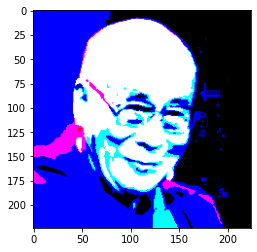

In [67]:
image = imgs[0].permute(1, 2, 0).numpy()
#image = image[:,:,::-1]
plt.imshow(image)

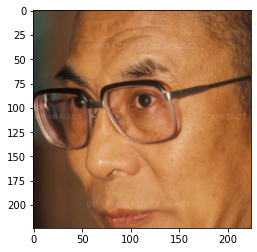

In [95]:
mean_bgr = np.array([91.4953, 103.8827, 131.0912])
from PIL import Image
img = Image.open('data/VGGFace2/data/test/n000001/0251_01.jpg')
#img = img[:, :, ::-1]  # RGB -> BGR
#img = img.astype(np.float32)
#img -= mean_bgr
%matplotlib inline
img = torchvision.transforms.Resize(256)(img)
img = torchvision.transforms.CenterCrop(224)(img)
plt.imshow(img)


In [22]:

for i in range(32):
    corr = []
    for j in range(32):
        if i == j:
            continue
        c = np.corrcoef(x[i].detach().numpy(),x[j].detach().numpy())[0,1]
        corr.append(c)
    print('max for i = {0}: j = {1}, corr = {2}'.format(i,np.argmax(corr),max(corr)))
    print('min for i = {0}: j = {1}, corr = {2}'.format(i,np.argmin(corr),min(corr)))


max for i = 0: j = 3, corr = 0.8738082140399105
min for i = 0: j = 27, corr = 0.6701345152674723
max for i = 1: j = 1, corr = 0.8841161974508585
min for i = 1: j = 9, corr = 0.7019495716534979
max for i = 2: j = 22, corr = 0.9041112553742207
min for i = 2: j = 27, corr = 0.6831778132834375
max for i = 3: j = 12, corr = 0.8803659468771325
min for i = 3: j = 18, corr = 0.6605653800837276
max for i = 4: j = 0, corr = 0.8738082140399104
min for i = 4: j = 23, corr = 0.6910006538213695
max for i = 5: j = 11, corr = 0.8782539039534552
min for i = 5: j = 26, corr = 0.6474061576612757
max for i = 6: j = 19, corr = 0.8972771465179901
min for i = 6: j = 27, corr = 0.6392474565051999
max for i = 7: j = 19, corr = 0.8953319312747281
min for i = 7: j = 27, corr = 0.6931070949185
max for i = 8: j = 1, corr = 0.881285497843304
min for i = 8: j = 9, corr = 0.6668955302772648
max for i = 9: j = 11, corr = 0.8819376258083071
min for i = 9: j = 29, corr = 0.6224770885216061
max for i = 10: j = 7, corr = 